# Helper Functions

In [178]:
import sys
import os

cwd = os.getcwd()
root_path = os.path.abspath('..\..')
sys.path.insert(0, root_path)

print(sys.path)

['c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD\\analysis\\raw', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\python39.zip', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\DLLs', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad', '', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\ronal\\AppData\\

In [179]:
import re
import json
import shutil
import zipfile
import numpy as np
import itertools
import pandas as pd

from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

from utils.fs import RESULTS_RAW_DIR
from utils.enums import Perspective

In [180]:
def list_subfolders_or_zip_files(experiment_name):
    experiment_path = os.path.join(RESULTS_RAW_DIR, experiment_name)
    run_names = [name for name in os.listdir(experiment_path) if os.path.isdir(os.path.join(experiment_path, name)) or (name.endswith('.zip') and os.path.isfile(os.path.join(experiment_path, name)))]
    return run_names

def get_temp_folder_path(directory, run_name):
    return os.path.join(RESULTS_RAW_DIR, directory, run_name)

def unzip_results(directory, run_name):
    if run_name.endswith(".zip"):
        zip_path = os.path.join(RESULTS_RAW_DIR, directory, run_name)
        if zipfile.is_zipfile(zip_path):
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                new_run_name = os.path.splitext(run_name)[0]
                zip_ref.extractall(get_temp_folder_path(directory, new_run_name))
            return new_run_name, True
    else:
        return run_name, False
    
def cleanup_temp_folders(directory, run_name):
    temp_path = get_temp_folder_path(directory, run_name)
    if os.path.exists(temp_path):
        shutil.rmtree(temp_path)
    

In [181]:
def load_results(run_name, verbose=False, directory=None):
    if directory:
        run_path = os.path.join(RESULTS_RAW_DIR, directory, run_name)
    else:
        run_path = os.path.join(RESULTS_RAW_DIR, run_name)

    np_files = [file for file in os.listdir(run_path) if file.endswith('.npy') or file.endswith('.npz')]

    loaded_data = {}

    # Load each .npy or .npz file and use the file name (without extension) as the key
    for np_file in np_files:
        file_path = os.path.join(run_path, np_file)
        key = os.path.splitext(np_file)[0]  # Get the file name without .npy or .npz extension

        if np_file.endswith('.npy'):
            # Directly load .npy files
            loaded_data[key] = np.load(file_path)
        elif np_file.endswith('.npz'):
            # Safely load .npz files and close the file afterward
            with np.load(file_path) as data:
                if len(data.files) == 1:
                    loaded_data[key] = data[data.files[0]]  # Extract the single array
                else:
                    raise ValueError(f"Multiple arrays in .npz file: {file_path}. Expected only one.")

        if verbose: print(f"{loaded_data[key]} \t {key}")

    return loaded_data

def load_config(run_name, directory=None):
    if directory:
        config_path = os.path.join(RESULTS_RAW_DIR, directory, run_name, "config.json")
    else:
        config_path = os.path.join(RESULTS_RAW_DIR, run_name, "config.json")

    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def get_buckets(keys):
    buckets = set()
    for key in keys:
        numbers = re.findall(r'\d+', key)
        buckets.update(map(int, numbers))
    if len(buckets) > 0:
        return sorted(buckets)
    return None

In [182]:
def plot_losses(results, labels, directory, run_name, perspective, level, bucket=None, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True):
    def scatter_plot(ax, results, labels):
        y_values = results
        x_values = np.arange(len(results))
        ax.scatter(x_values[labels == 0], y_values[labels == 0], c='grey', s=3, label='Normal Prefixes', zorder=1)
        ax.scatter(x_values[labels == 1], y_values[labels == 1], c='red', s=3, label='Anomalous Prefixes', zorder=2)
        ax.grid(True)

    # Normalize results
    results = np.interp(results, (results.min(), results.max()), (0, 1))

    subtitle = f'{directory}     {run_name}'
    if len(results) == 0:
        print(f'ERROR no results found for {subtitle}')
    else:
        fig, ax = plt.subplots(figsize=(15, 6))

        labels = labels[:, perspective]
        scatter_plot(ax, results, labels)
        
        perspective_name = Perspective.values()[perspective]

        bucket_string = ''
        if bucket is not None:
            bucket_string = f'with bucket size {str(bucket)}'
        
        title = f'Error per Prefix on the {perspective_name} perspective at {level} level {bucket_string}'
        
        # Print to keep track of plotting
        # print(f'\t {title}')
        
        plt.title(f'{title}\n{subtitle}')
        plt.xlabel('Prefix Index')
        plt.ylabel('Loss')
        
        if zoom:
            axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

            scatter_plot(axins, results, labels)
            axins.set_xlim(zoom[0])
            axins.set_ylim(zoom[1])
            _,_ = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=3)

        plt.xlabel('Case Index')
        plt.ylabel('Error')
        plt.legend(loc='upper right')
        
        plot_path = f"plots\{directory}\{run_name} "
        os.makedirs(plot_path, exist_ok=True)
        plt.savefig(f"{plot_path}\{perspective_name}_{level}_{bucket_string}.png", format='png', dpi=300)
        
        if show_plots:
            plt.show()
        plt.close()

def bucket_plot_losses(results_name, labels_name, run_name, directory, bucket_lengths, results, perspective, level, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True, pbar=None):
    if bucket_lengths is None:
        plot_losses(
            results=results[f'{results_name}'], 
            labels=results[f'{labels_name}'],
            directory=directory,
            run_name=run_name, perspective=perspective, level=level, bucket=None, zoom=zoom, show_plots=show_plots)
        if pbar:
            pbar.update(1)       
    else:
        for bucket in bucket_lengths:
            plot_losses(
                results=results[f'{results_name}_{bucket}'], 
                labels=results[f'{labels_name}_{bucket}'],
                directory=directory,
                run_name=run_name, perspective=perspective, level=level, bucket=bucket, zoom=zoom, show_plots=show_plots)
            if pbar:
                pbar.update(1)  


In [183]:
def get_indexes_by_value(arr):
    value_to_indexes = {}
    for index, value in enumerate(arr):
        if value not in value_to_indexes:
            value_to_indexes[value] = []
        value_to_indexes[value].append(index)
    return value_to_indexes

def normalize(array):
    array = np.array(array)
    return np.interp(array, (array.min(), array.max()), (0, 1))

# Function to extract the number after the last underscore
def extract_number(key):
    try:
        return int(key.split('_')[-1])
    except:
        return 0

In [184]:
def process_attribute_labels(output, values, case_length, perspective, perspective_label_indices):
    # print(values.shape)

    perspective_value = values[perspective, :, :, :]
    # print(perspective_value.shape)

    perspective_masked = perspective_value[:, :case_length, :]
    # print(perspective_masked.shape)

    perspective_indexed = perspective_masked[:,:,perspective_label_indices[perspective]]
    # print(perspective_indexed.shape)

    perspective_attribute_value = perspective_indexed.reshape(-1) # Flatten the output
    # print(perspective_attribute_value.shape)

    output.append(perspective_attribute_value)

In [185]:
def reshape_data_for_scoring(results, perspective_label_indices):
    labels_DAE_attribute_Arrival_Time = []
    labels_DAE_attribute_Workload = []
    labels_DAE_attribute_Order = []
    labels_DAE_attribute_Attribute  = []

    labels_DAE_event = []
    labels_DAE_trace = []

    result_DAE_attribute_Arrival_Time = []
    result_DAE_event_Arrival_Time = []
    result_DAE_trace_Arrival_Time = []
    result_DAE_attribute_Workload = []
    result_DAE_event_Workload = []
    result_DAE_trace_Workload = []
    result_DAE_attribute_Order = []
    result_DAE_event_Order = []
    result_DAE_trace_Order = []
    result_DAE_attribute_Attribute = []
    result_DAE_event_Attribute = []
    result_DAE_trace_Attribute = []

    for (key, value) in results.items():
        # print(key, value.shape)
        try:
            length = int(key.split('_')[-1])
            perspective = key.split('_')[-2]
        except: # If it fails it mean there is no bucket, then the length of every trace is max length
            if 'attribute' in key or 'event' in key:
                length = value.shape[1]
            perspective = key.split('_')[-1]
        
        if 'losses' in key:
            continue
        elif 'labels' in key:
            if 'attribute' in key:
                transposed_value = np.transpose(value, (3,0,1,2))# [:, :, :length, :]

                process_attribute_labels(
                    output=labels_DAE_attribute_Arrival_Time,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.ARRIVAL_TIME,
                    perspective_label_indices=perspective_label_indices)
                process_attribute_labels(
                    output=labels_DAE_attribute_Attribute,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.ATTRIBUTE,
                    perspective_label_indices=perspective_label_indices)
                process_attribute_labels(
                    output=labels_DAE_attribute_Order,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.ORDER,
                    perspective_label_indices=perspective_label_indices)
                process_attribute_labels(
                    output=labels_DAE_attribute_Workload,
                    values=transposed_value, 
                    case_length=length, 
                    perspective=Perspective.WORKLOAD,
                    perspective_label_indices=perspective_label_indices)

                # # print(perspective_value.shape)
                # perspective_value = perspective_value.reshape(perspective_value.shape[0], -1)
                # # print(perspective_value.shape)
                # labels_DAE_attribute.append(perspective_value)
            elif 'event' in key:
                perspective_value = np.transpose(value, (2,0,1))[:, :, :length]
                perspective_value = perspective_value.reshape(perspective_value.shape[0], -1)
                labels_DAE_event.append(perspective_value)
            elif 'trace' in key:
                perspective_value = np.transpose(value, (1,0))
                # print(perspective_value.shape)
                labels_DAE_trace.append(perspective_value)
        elif 'result' in key:
            if 'attribute' in key:
                # print(value.shape)
                # value_max = np.max(value, axis=2)
                # print(value.shape, normalize(value.reshape(-1)).shape, perspective)
                # print(value.shape)
                value = normalize(value.reshape(-1))
                # print(value.shape)
                if 'Arrival Time' in perspective:
                    result_DAE_attribute_Arrival_Time.append(value)
                elif 'Order' in perspective:
                    result_DAE_attribute_Order.append(value)
                elif 'Workload' in perspective:
                    result_DAE_attribute_Workload.append(value)
                elif 'Attribute' in perspective:
                    result_DAE_attribute_Attribute.append(value)
            if 'event' in key:
                value = normalize(value.reshape(-1))
                if 'Arrival Time' in perspective:
                    result_DAE_event_Arrival_Time.append(value)
                elif 'Order' in perspective:
                    result_DAE_event_Order.append(value)
                elif 'Workload' in perspective:
                    result_DAE_event_Workload.append(value)
                elif 'Attribute' in perspective:
                    result_DAE_event_Attribute.append(value)
            elif 'trace' in key:
                value = normalize(value)
                if 'Arrival Time' in perspective:
                    result_DAE_trace_Arrival_Time.append(value)
                elif 'Order' in perspective:
                    result_DAE_trace_Order.append(value)
                elif 'Workload' in perspective:
                    result_DAE_trace_Workload.append(value)
                elif 'Attribute' in perspective:
                    result_DAE_trace_Attribute.append(value)


    # labels_DAE_attribute = np.concatenate(labels_DAE_attribute, axis=1)
    labels_DAE_event = np.concatenate(labels_DAE_event, axis=1)    
    labels_DAE_trace = np.concatenate(labels_DAE_trace, axis=1)

    # print(labels_DAE_attribute.shape)

    # print(np.concatenate(result_DAE_event_Order, axis=0).shape)
    # print(result_DAE_attribute_Attribute.shape)
    # print(result_DAE_attribute_Arrival_Time.shape)
    # print(result_DAE_attribute_Workload.shape)

    labels_DAE_attribute = [
        np.concatenate(labels_DAE_attribute_Order, axis=0),
        np.concatenate(labels_DAE_attribute_Attribute, axis=0),
        np.concatenate(labels_DAE_attribute_Arrival_Time, axis=0),
        np.concatenate(labels_DAE_attribute_Workload, axis=0)
    ]

    result_DAE_attribute = [
        np.concatenate(result_DAE_attribute_Order, axis=0),
        np.concatenate(result_DAE_attribute_Attribute, axis=0),
        np.concatenate(result_DAE_attribute_Arrival_Time, axis=0),
        np.concatenate(result_DAE_attribute_Workload, axis=0)
    ]

    result_DAE_event = [
        np.concatenate(result_DAE_event_Order, axis=0),
        np.concatenate(result_DAE_event_Attribute, axis=0),
        np.concatenate(result_DAE_event_Arrival_Time, axis=0),
        np.concatenate(result_DAE_event_Workload, axis=0)
    ]

    result_DAE_trace = [
        np.concatenate(result_DAE_trace_Order, axis=0),
        np.concatenate(result_DAE_trace_Attribute, axis=0),
        np.concatenate(result_DAE_trace_Arrival_Time, axis=0),
        np.concatenate(result_DAE_trace_Workload, axis=0)
    ]

    return labels_DAE_attribute, labels_DAE_event, labels_DAE_trace, result_DAE_attribute, result_DAE_event, result_DAE_trace

In [186]:
def calculate_f1(precision, recall):
    # Check if both precision and recall are zero to avoid division by zero
    precision[precision == 0] = 1e-6
    recall[recall == 0] = 1e-6

    if np.any(precision != 0) and np.any(recall != 0):
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0

def calculate_scores(y_trues, pred_probs, perspective):
    y_true = y_trues[perspective][:]
    pred_prob = pred_probs[perspective][:]

    # ROC-AUC
    roc_auc = roc_auc_score(y_true, pred_prob)

    # PR-AUC
    pr_auc = average_precision_score(y_true, pred_prob)

    # F1-Score
    precision, recall, thresholds = precision_recall_curve(y_true=y_true, probas_pred=pred_prob)
    # print(precision.shape)
    # print(recall.shape)
    f1s=calculate_f1(precision,recall)
    f1s[np.isnan(f1s)] = 0
    # print(f1s)
    f1_best_index=np.argmax(f1s)
    # recall_best_index=np.mean(recall)
    # precision_best_index=np.mean(precision)

    return roc_auc, pr_auc, f1s[f1_best_index], np.mean(precision), np.mean(recall)

In [187]:
def score(run):
    results = run['results']
    config = run['config']
    timestamp = run['timestamp']
    index = run['index']

    sorted_results = dict(sorted(results.items(), key=lambda x: extract_number(x[0])))
    perspective_label_indices = get_indexes_by_value(config['attribute_perspectives_original'])

    (
        labels_DAE_attribute, 
        labels_DAE_event, 
        labels_DAE_trace, 
        result_DAE_attribute, 
        result_DAE_event, 
        result_DAE_trace
    ) = reshape_data_for_scoring(results=sorted_results, perspective_label_indices=perspective_label_indices)

    level = ['trace', 'event', 'attribute']
    datasets = [labels_DAE_trace, labels_DAE_event, labels_DAE_attribute]
    results = [result_DAE_trace, result_DAE_event, result_DAE_attribute]
    perspectives = Perspective.keys()

    scores = []
    for (level, dataset, result), perspective in itertools.product(zip(level, datasets, results), perspectives):
        try:
            roc_auc, pr_auc, f1, precision, recall = calculate_scores(dataset, result, perspective)
            # print(level, perspective, roc_auc, pr_auc)

            scores.append({
                # High level differentiatiors
                'run_name':config['run_name'],
                'model':config['model'],
                'dataset':config['dataset'],
                'timestamp':timestamp,
                'index':index,
                # 'repeat':config['repeat'],
                # Level/Perspectives
                'level': level,
                'perspective': Perspective.values()[perspective],
                # Scores
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'f1': f1,
                'precision':precision,
                'recall':recall,
                'run_time': config['run_time'],
                # Config
                'batch_size':config['batch_size'],
                'prefix':config['prefix'],
                'buckets':config['bucket_boundaries'],
                'categorical_encoding':config['categorical_encoding'],
                'numerical_encoding':config['numerical_encoding'],
                'vector_size':config['vector_size'],
                'window_size':config['window_size'] 
            })
        except:
            print(level, perspective)

    return pd.DataFrame(scores)

In [188]:
def load_score_dataframe(file_path):
    if os.path.exists(file_path):
        loaded_df = pd.read_pickle(file_path)
        print("DataFrame loaded successfully!")
        return loaded_df
    else:
        print(f"The file {file_path} does not exist.")
        return None

# Loading Runs

In [189]:
directories = [
    # 'Experiment_Real_World_All_Models',
    # 'Experiment_Real_World_Debug',
    # 'Experiment_Synthetic_All_Models',
    # 'Experiment_Prefix',
    # 'Experiment_Finetuning_T2V_Window_Vector_Sizes'
    # 'Experiment_Finetuning_W2V_Window_Vector_Sizes',
    # 'Experiment_Finetuning_Fixed_Vector_Vector_Sizes',
    # 'Experiment_Anomaly_Percentage_v2',
    # 'Experiment_Synthetic_Dataset_v4',
    'Experiment_Prefix_v2',
    # 'Experiment_Batch_Size',
    ] 

filter_beginning_percentage = 10

recalculate = True

score_results = True
score_summary = True

rank_encoders = True

plot_results = True
show_plots = False


In [190]:
directory = directories[-1]
print(directory)

Experiment_Prefix_v2


In [191]:
run_list = list_subfolders_or_zip_files(directory)
print(run_list)
print(run_list[0])

['24-11-24-18-23_DAE_EncodingCategorical.ONE_HOT_EncodingNumerical.MIN_MAX_SCALING (2).zip', '24-11-24-18-23_DAE_EncodingCategorical.ONE_HOT_EncodingNumerical.MIN_MAX_SCALING (3).zip', '24-11-24-18-23_DAE_EncodingCategorical.ONE_HOT_EncodingNumerical.MIN_MAX_SCALING.zip', '24-11-24-18-24_DAE_EncodingCategorical.ONE_HOT_EncodingNumerical.MIN_MAX_SCALING.zip', '24-11-24-18-24_DAE_EncodingCategorical.WORD_2_VEC_ATC_EncodingNumerical.MIN_MAX_SCALING (2).zip', '24-11-24-18-24_DAE_EncodingCategorical.WORD_2_VEC_ATC_EncodingNumerical.MIN_MAX_SCALING (3).zip', '24-11-24-18-24_DAE_EncodingCategorical.WORD_2_VEC_ATC_EncodingNumerical.MIN_MAX_SCALING.zip', '24-11-24-18-25_DAE_EncodingCategorical.ONE_HOT_EncodingNumerical.MIN_MAX_SCALING (2).zip', '24-11-24-18-25_DAE_EncodingCategorical.ONE_HOT_EncodingNumerical.MIN_MAX_SCALING.zip', '24-11-24-18-29_DAE_EncodingCategorical.WORD_2_VEC_ATC_EncodingNumerical.MIN_MAX_SCALING (2).zip', '24-11-24-18-29_DAE_EncodingCategorical.WORD_2_VEC_ATC_EncodingNume

In [192]:
score_path = f"plots\{directory}\\"
score_file = f"scores_raw_df.pkl"
all_scores_df = None

# Check if scores_raw_df.pkl exists and if yes skip reloading all data, force recalculation if set to true
if not recalculate:
    all_scores_df = load_score_dataframe(score_path + score_file)

In [193]:
runs = []
scores_dfs = []

# If no scores_raw_df.pkl exists, recalulate is true or plotting individual runs start loading all data from raw
if all_scores_df is None or recalculate is True or plot_results is True:
    for index, run_name in enumerate(tqdm(run_list)):
        # try:
            # If needed unzip the data
            run_name, from_zip = unzip_results(directory, run_name)

            # Loading the data
            results = load_results(run_name=run_name, directory=directory)
            config = load_config(run_name=run_name, directory=directory)
            buckets = get_buckets(results.keys())
            timestamp = run_name.split('_')[0]

            # If needed clean up temp folder
            if from_zip:
                cleanup_temp_folders(directory, run_name)
            
            # If set filter the first % of results from the run to allow the scoring some grace period
            if filter_beginning_percentage != 0:
                for key, value in results.items():
                    filter_index = int(value.shape[0] / filter_beginning_percentage)
                    # print(filter_index)
                    results[key] = value[filter_index:]

            run = {
                "name": run_name,
                "timestamp": timestamp,
                "results": results,
                "config": config,
                "buckets": buckets,
                "index": index,
            }

            # If no preloaded scores exist  
            if (all_scores_df is None or recalculate is True) and (score_results is True or rank_encoders is True): 
                scores_df = score(run=run)
                scores_dfs.append(scores_df)

            # Only save to runs if plotting results otherwise it is wasting memory
            if plot_results:
                runs.append(run)
        # except:
        #     continue

# Save the scores dataframe to disk if it has calculated
if len(scores_dfs) != 0:
    all_scores_df = pd.concat(scores_dfs, ignore_index=True)
    os.makedirs(score_path, exist_ok=True)
    all_scores_df.to_pickle(score_path + score_file)

print(len(runs))

100%|██████████| 24/24 [00:54<00:00,  2.26s/it]

24


# Plot Results

In [194]:
if plot_results:
    results_config = [
        ('result_DAE_trace_Order', 'labels_DAE_trace', Perspective.ORDER, 'trace'),
        ('result_DAE_trace_Attribute', 'labels_DAE_trace', Perspective.ATTRIBUTE, 'trace'),
        ('result_DAE_trace_Arrival Time', 'labels_DAE_trace', Perspective.ARRIVAL_TIME, 'trace'),
        ('result_DAE_trace_Workload', 'labels_DAE_trace', Perspective.WORKLOAD, 'trace'),
    ]

    nr_buckets = 0
    for run in runs:
        if run["buckets"] is None:
            nr_buckets += 1
        else:
            nr_buckets += len(run["buckets"])

    total_iterations = nr_buckets * len(results_config)
    with tqdm(total=total_iterations, desc="Generating Plots") as pbar:
        for run in runs:
            # print(f"Generating: {directory}\t{run_name}")
            for config in results_config:
                # try:
                bucket_plot_losses(
                    results_name=config[0], 
                    labels_name=config[1],
                    directory=directory,
                    run_name=run["name"],
                    bucket_lengths=run["buckets"],
                    results=run["results"],
                    perspective=config[2],
                    level=config[3],
                    zoom=None,
                    show_plots=show_plots,
                    pbar=pbar)
                # except:
                #     print("Error loading ")


Generating Plots: 100%|██████████| 432/432 [03:26<00:00,  2.09it/s]


# Score Results

In [195]:
all_scores_df.shape

(288, 20)

In [196]:
all_scores_df.head(5)

,run_name,model,dataset,timestamp,index,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size
0,Experiment_Prefix_2_45509,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,24-11-24-18-23,0,trace,Order,0.543148,0.316161,0.414945,0.294124,0.532134,43.102888,8,False,None,One Hot,Min Max Scaling,0,0
1,Experiment_Prefix_2_45509,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,24-11-24-18-23,0,trace,Attribute,0.519010,0.272949,0.418000,0.272169,0.510768,43.102888,8,False,None,One Hot,Min Max Scaling,0,0
2,Experiment_Prefix_2_45509,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,24-11-24-18-23,0,trace,Arrival Time,0.494221,0.239090,0.401361,0.236893,0.495669,43.102888,8,False,None,One Hot,Min Max Scaling,0,0
3,Experiment_Prefix_2_45509,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,24-11-24-18-23,0,trace,Workload,0.690258,0.480517,0.499070,0.455753,0.537128,43.102888,8,False,None,One Hot,Min Max Scaling,0,0
4,Experiment_Prefix_2_45509,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,24-11-24-18-23,0,event,Order,0.417953,0.020479,0.049952,0.019313,0.420167,43.102888,8,False,None,One Hot,Min Max Scaling,0,0


In [197]:
all_scores_df["buckets"] = all_scores_df["buckets"].astype(str)

In [198]:
# Generate additional rows for the encoding methods combined
group_cols = [
    "run_name", "model", "dataset", "level", "perspective", "batch_size", "vector_size", "window_size", "prefix", "buckets"
]
averages_methods = (
    all_scores_df.groupby(group_cols)
    .agg({
        "roc_auc": "mean", 
        "pr_auc": "mean", 
        "f1": "mean", 
        "precision": "mean", 
        "recall": "mean",
        "run_time": "mean"})
    .reset_index()
)
averages_methods["categorical_encoding"] = "All"
averages_methods["timestamp"] = "Average"


result_methods_df = pd.concat([all_scores_df, averages_methods], ignore_index=True)

In [199]:
averages_methods.head(1)

,run_name,model,dataset,level,perspective,batch_size,vector_size,window_size,prefix,buckets,roc_auc,pr_auc,f1,precision,recall,run_time,categorical_encoding,timestamp
0,Experiment_Prefix_1_11409,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,attribute,Arrival Time,8,0,0,False,None,0.508413,0.024551,0.053141,0.024256,0.50804,42.974525,All,Average


In [200]:
print(all_scores_df.shape)
print(averages_methods.shape)
print(result_methods_df.shape)

(288, 20)
(288, 18)
(576, 20)


In [201]:
averages_methods.head(1)

,run_name,model,dataset,level,perspective,batch_size,vector_size,window_size,prefix,buckets,roc_auc,pr_auc,f1,precision,recall,run_time,categorical_encoding,timestamp
0,Experiment_Prefix_1_11409,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,attribute,Arrival Time,8,0,0,False,None,0.508413,0.024551,0.053141,0.024256,0.50804,42.974525,All,Average


In [202]:
# Generate additional rows for the perspectives combined
group_cols = [
    "run_name", "model", "dataset", "timestamp", "level", "categorical_encoding", "batch_size", "run_time", "vector_size", "window_size", "prefix", "buckets"
]
averages_perspective = (
    result_methods_df.groupby(group_cols)
    .agg({"roc_auc": "mean", "pr_auc": "mean", "f1": "mean", "precision": "mean", "recall": "mean"})
    .reset_index()
)
averages_perspective["perspective"] = "All"


result_df = pd.concat([result_methods_df, averages_perspective], ignore_index=True)

In [203]:
print(all_scores_df.shape)
print(averages_perspective.shape)
print(result_df.shape)

(288, 20)
(144, 18)
(720, 20)


In [204]:
result_df.head(1)

,run_name,model,dataset,timestamp,index,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size
0,Experiment_Prefix_2_45509,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,24-11-24-18-23,0.0,trace,Order,0.543148,0.316161,0.414945,0.294124,0.532134,43.102888,8,False,None,One Hot,Min Max Scaling,0,0


In [205]:
# Generate additional columns used in analysis
result_df["dataset_size"] = result_df["dataset"].str.split('_').str[3]
result_df["anomaly_percentage"] = result_df["dataset"].str.split('_').str[4]
result_df["anomaly_percentage"] = result_df["anomaly_percentage"].astype(float)
result_df["batch_size"] = result_df["batch_size"].astype(str)
result_df["vector_size"] = result_df["vector_size"].astype(str)
result_df["vector_window_size"] = result_df["vector_size"].astype(str) + '/' + result_df["window_size"].astype(str)
result_df["prefix"] = result_df["prefix"].astype(str)
result_df["prefix_buckets"] = result_df["prefix"].astype(str) + '/' + result_df["buckets"].astype(str)

In [206]:
result_df.shape

(720, 24)

In [207]:
result_df.tail(1)

,run_name,model,dataset,timestamp,index,level,perspective,roc_auc,pr_auc,f1,...,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size,dataset_size,anomaly_percentage,vector_window_size,prefix_buckets
719,Experiment_Prefix_3_30425,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,Average,NaN,trace,All,0.553548,0.22963,0.335323,...,True,None,All,NaN,0,0,gigantic,0.45,0/0,True/None


In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_score(data, score_type, level, ax, label_name, xlabel_name):
    subset = data[data["level"] == level]
    
    sns.lineplot(
        data=subset,
        x=label_name,
        y=score_type,
        hue="perspective",
        style="categorical_encoding",
        markers=True,
        dashes=False,
        ax=ax
    )
    
    ax.set_title(f"{score_type.capitalize()} Scores (Level={level.capitalize()})")
    ax.set_xlabel(xlabel_name)
    ax.set_ylabel(f"{score_type.capitalize()}" if level=='trace' else "")
    ax.tick_params(axis="x", rotation=45)

def plot_scores(data, directory, title, label_name, xlabel_name, summary=True, filter_beginning_percentage=0):
    levels = ["trace", "event", "attribute"]
    
    # Create a figure with 3 rows and 3 columns for the PR AUC, ROC AUC and F1 plots
    if summary:
        fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=False)
    else:
        fig, axes = plt.subplots(6, 3, figsize=(18, 18), sharex=True, sharey=False)
    
    handles, labels = [], []

    for i, level in enumerate(levels):
        plot_single_score(data, "f1", level, axes[0, i], label_name, xlabel_name)
        plot_single_score(data, "run_time", level, axes[1, i], label_name, xlabel_name)
        if not summary:
            plot_single_score(data, "pr_auc", level, axes[2, i], label_name, xlabel_name)
            plot_single_score(data, "roc_auc", level, axes[3, i], label_name, xlabel_name)
            plot_single_score(data, "precision", level, axes[4, i], label_name, xlabel_name)
            plot_single_score(data, "recall", level, axes[5, i], label_name, xlabel_name)

        if not handles and not labels:  # Collect handles and labels only once
            handles, labels = axes[0, i].get_legend_handles_labels()
        
        axes[0, i].legend().remove()
        axes[1, i].legend().remove()
        if not summary:
            axes[2, i].legend().remove()
            axes[3, i].legend().remove()
            axes[4, i].legend().remove()
            axes[5, i].legend().remove()

    
    # Add a single legend for both rows
    fig.legend(
        handles,
        labels,
        title="Perspective & Encoding",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=3
    )
    
    # Adjust layout to avoid overlap
    plt.tight_layout()

    plot_path = f"plots\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(f"{plot_path}\experimental_results_{title}_{filter_beginning_percentage}.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()

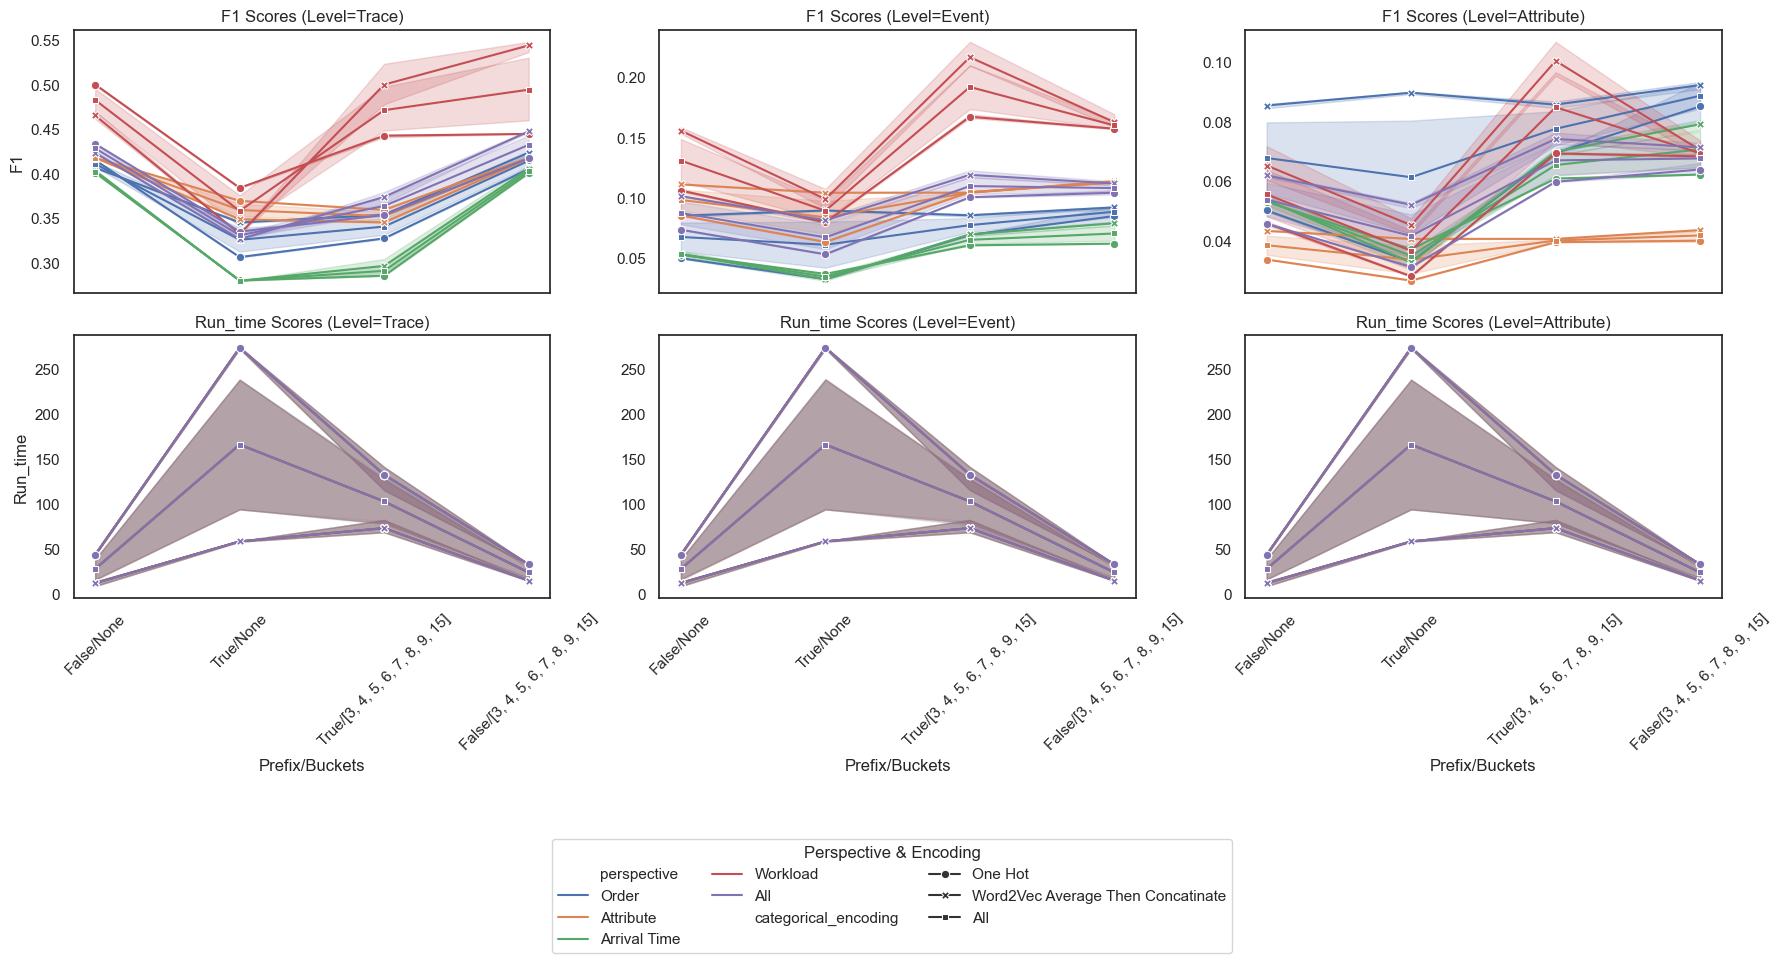

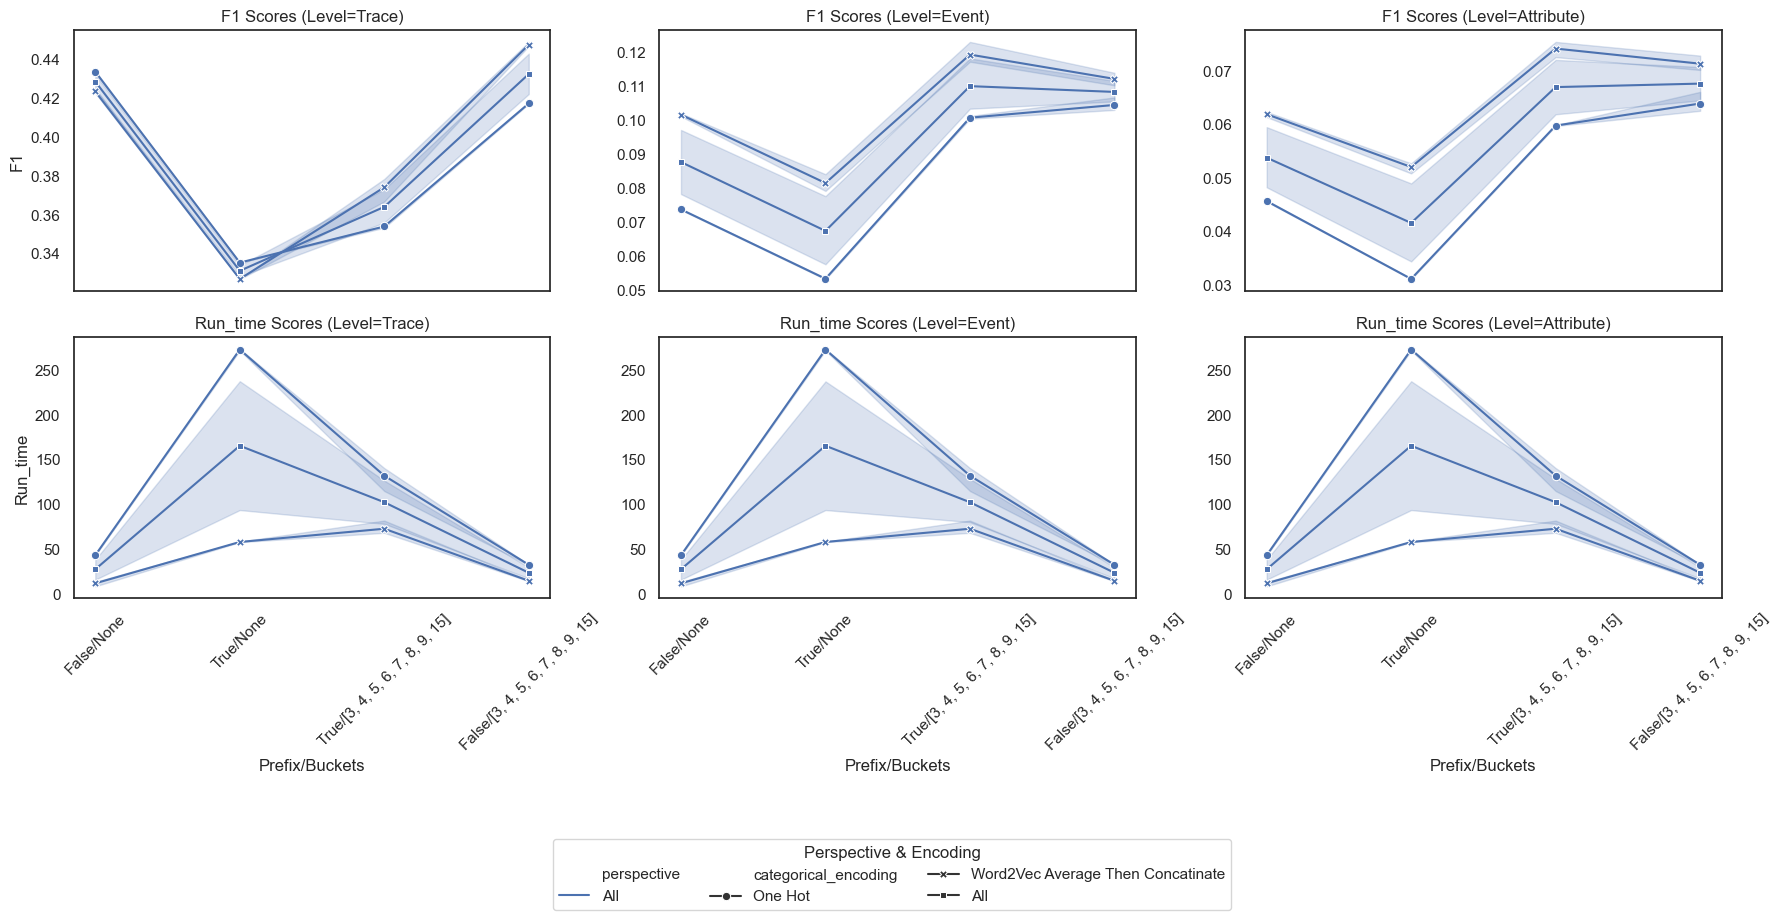

In [209]:
if "Experiment_Anomaly_Percentage" in directory:
    xlabel_name="Anomaly Percentages"
    label_name="anomaly_percentage"
    plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

elif "Experiment_Synthetic_Dataset" in directory:
    xlabel_name="Dataset Sizes"
    label_name="dataset_size"
    plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

elif "Experiment_Batch_Size" in directory:
    xlabel_name="Batch Sizes"
    label_name="batch_size"
    plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

elif "Experiment_Prefix_v2" in directory:
    xlabel_name="Prefix/Buckets"
    label_name="prefix_buckets"
    plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
   

elif "Experiment_Finetuning_Fixed_Vector_Vector_Sizes" in directory:
    filtered_result_df = result_df[result_df["categorical_encoding"] == "Fixed Vector"]

    xlabel_name="Vector Sizes"
    label_name="vector_size"
    plot_scores(filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    plot_scores(filtered_result_df[filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)  

elif "Experiment_Finetuning_W2V_Window_Vector_Sizes" in directory or "Experiment_Finetuning_T2V_Window_Vector_Sizes" in directory:
    filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

    xlabel_name="Vector/Window Sizes"
    label_name="vector_window_size"
    plot_scores(filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    plot_scores(filtered_result_df[filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)       

# Rank Encoders

In [210]:
all_scores_df["dataset_short_name"] = all_scores_df["dataset"].str.split('_').str[3] + "/" + all_scores_df["dataset"].str.split('_').str[4]
# result_df["anomaly_percentage"] = result_df["anomaly_percentage"].astype(float)
# result_df["batch_size"] = result_df["batch_size"].astype(str)
# result_df["vector_size"] = result_df["vector_size"].astype(str)
# result_df["vector_window_size"] = result_df["vector_size"].astype(str) + '/' + result_df["window_size"].astype(str)
# result_df["prefix"] = result_df["prefix"].astype(str)
# result_df["prefix_buckets"] = result_df["prefix"].astype(str) + '/' + result_df["buckets"].astype(str)

In [211]:
all_scores_df.head(1)

,run_name,model,dataset,timestamp,index,level,perspective,roc_auc,pr_auc,f1,...,recall,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size,dataset_short_name
0,Experiment_Prefix_2_45509,DAE,process_log_24-11-21-12-07_gigantic_0.45_4_9.j...,24-11-24-18-23,0,trace,Order,0.543148,0.316161,0.414945,...,0.532134,43.102888,8,False,None,One Hot,Min Max Scaling,0,0,gigantic/0.45


In [212]:
grouped_all_levels = all_scores_df.groupby(['dataset_short_name', 'categorical_encoding', 'level'])[['f1']].mean().reset_index()
grouped_combined_levels = all_scores_df.groupby(['dataset_short_name', 'categorical_encoding'])[['f1']].mean().reset_index()
grouped_combined_levels['level'] = 'combined'

In [213]:
grouped_all_levels.shape

(6, 4)

In [214]:
grouped_combined_levels.shape

(2, 4)

In [215]:
# grouped_combined_levels['index'] = [None] 
grouped_levels = pd.concat([grouped_all_levels, grouped_combined_levels], axis=0, ignore_index=True)
grouped_levels.shape

(8, 4)

In [216]:
grouped_levels.head()

,dataset_short_name,categorical_encoding,level,f1
0,gigantic/0.45,One Hot,attribute,0.050127
1,gigantic/0.45,One Hot,event,0.083028
2,gigantic/0.45,One Hot,trace,0.385075
3,gigantic/0.45,Word2Vec Average Then Concatinate,attribute,0.064848
4,gigantic/0.45,Word2Vec Average Then Concatinate,event,0.103534


In [217]:
grouped_levels['f1_rank'] = grouped_levels.groupby(['dataset_short_name', 'level'])['f1'].rank(ascending=False)

In [218]:
grouped_levels.shape

(8, 5)

In [219]:
grouped_levels.head()

,dataset_short_name,categorical_encoding,level,f1,f1_rank
0,gigantic/0.45,One Hot,attribute,0.050127,2.0
1,gigantic/0.45,One Hot,event,0.083028,2.0
2,gigantic/0.45,One Hot,trace,0.385075,2.0
3,gigantic/0.45,Word2Vec Average Then Concatinate,attribute,0.064848,1.0
4,gigantic/0.45,Word2Vec Average Then Concatinate,event,0.103534,1.0


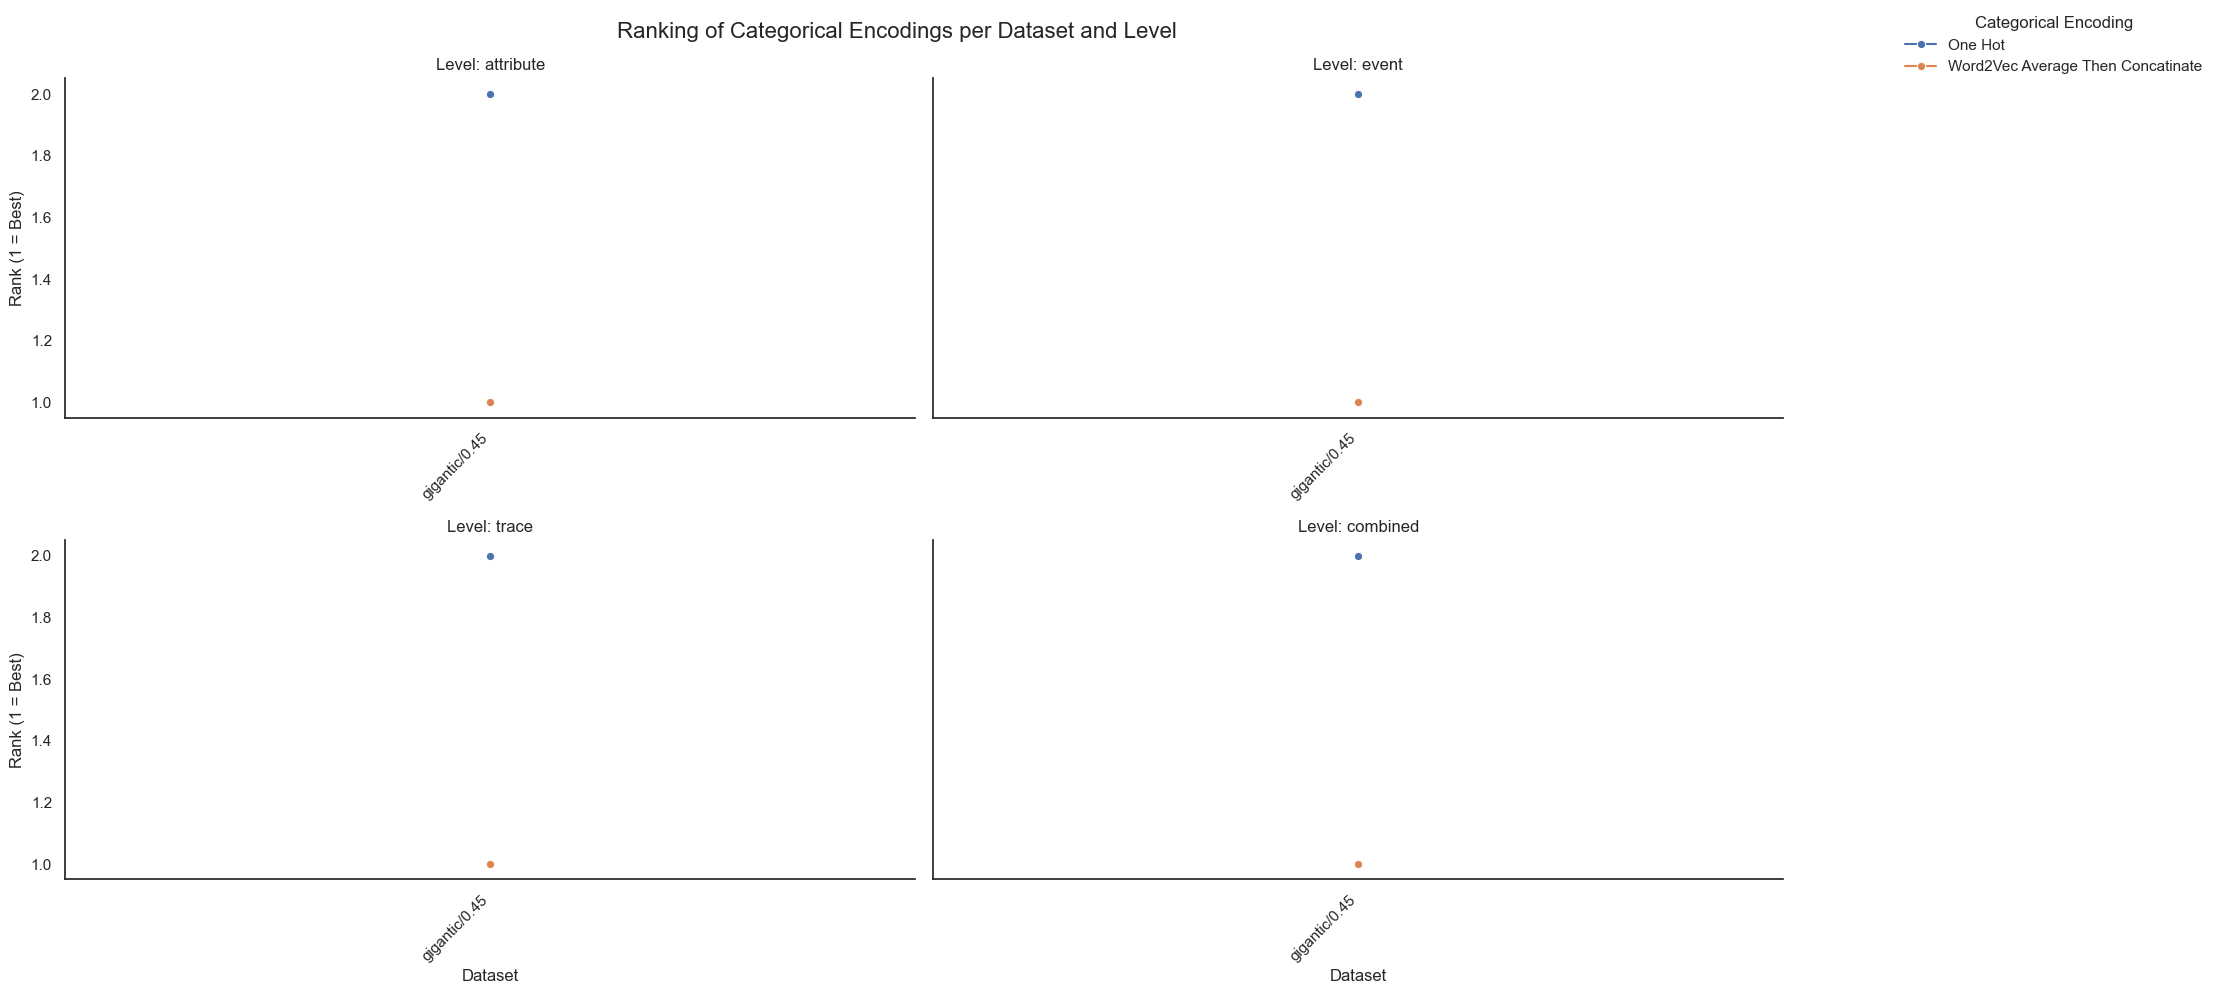

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Create a Seaborn FacetGrid for each level
sns.set_theme(style="white")
g = sns.FacetGrid(grouped_levels, col="level", sharey=True, sharex=False, height=5, aspect=1.5, col_wrap=2)

# Step 4: Plot the ranks with a lineplot for each categorical_encoding
g.map_dataframe(
    sns.lineplot,
    x="dataset_short_name",
    y="f1_rank",
    hue="categorical_encoding",
    marker="o"
)

# Step 5: Customize the plot
g.set_axis_labels("Dataset", "Rank (1 = Best)")
g.set_titles("Level: {col_name}")
plt.subplots_adjust(top=0.85)
g.figure.suptitle("Ranking of Categorical Encodings per Dataset and Level", fontsize=16)

# for ax in g.axes.flatten():
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#     ax.grid(False)

for ax in g.axes.flatten():
    # Get the current tick positions and labels
    tick_positions = ax.get_xticks()
    tick_labels = ax.get_xticklabels()

    # Set the ticks and labels explicitly with rotation
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

    ax.grid(False)  # Turn off gridlines
    
g.add_legend(title="Categorical Encoding", loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()

plot_path = f"plots\{directory}"
os.makedirs(plot_path, exist_ok=True)
plt.savefig(f"{plot_path}\encoding_ranking_per_dataset.png", format='png', dpi=300, bbox_inches="tight")

plt.show()

In [221]:
average_rank_df = grouped_levels.groupby(['categorical_encoding', 'level'])['f1_rank'].mean().reset_index()
average_rank_df = average_rank_df.rename(columns={'f1_rank': 'average_rank'})
average_rank_df['average_rank'] = average_rank_df['average_rank'].round(2)

average_f1_df = grouped_levels.groupby(['categorical_encoding', 'level'])['f1'].mean().reset_index()
average_rank_df = pd.merge(average_rank_df, average_f1_df, on=['categorical_encoding', 'level'])

average_rank_df = average_rank_df.sort_values(by=['level', 'average_rank'], ascending=[True, True])

In [222]:
average_rank_df

,categorical_encoding,level,average_rank,f1
4,Word2Vec Average Then Concatinate,attribute,1.0,0.064848
0,One Hot,attribute,2.0,0.050127
5,Word2Vec Average Then Concatinate,combined,1.0,0.187140
1,One Hot,combined,2.0,0.172744
6,Word2Vec Average Then Concatinate,event,1.0,0.103534
2,One Hot,event,2.0,0.083028
7,Word2Vec Average Then Concatinate,trace,1.0,0.393037
3,One Hot,trace,2.0,0.385075


In [223]:
def plot_rankings(data_df, rank_column='average_rank'):
    levels = ['combined', 'trace', 'event', 'attribute']
    fig, axes = plt.subplots(1, len(levels), figsize=(15, 4), sharey=True)

    for i, level in enumerate(levels):
        ax = axes[i]
        level_data = data_df[data_df['level'] == level]
        
        ordered_categories = level_data.sort_values(rank_column)['categorical_encoding']
        
        ax.bar(ordered_categories, level_data.sort_values(rank_column)[rank_column], color='skyblue')

        ax.set_title(f"Level: {level}")
        ax.set_ylabel("Average Rank (Lower = Better)")
        ax.tick_params(axis="x", rotation=90)
        ax.grid(False)
        ax.grid(axis='y', linestyle='--', color='gray', alpha=0.5)


    # plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.suptitle("Average Rank Categorical Encoding methods per Level", fontsize=16)

    plot_path = f"plots\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(f"{plot_path}\encoding_rankings_summary.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()

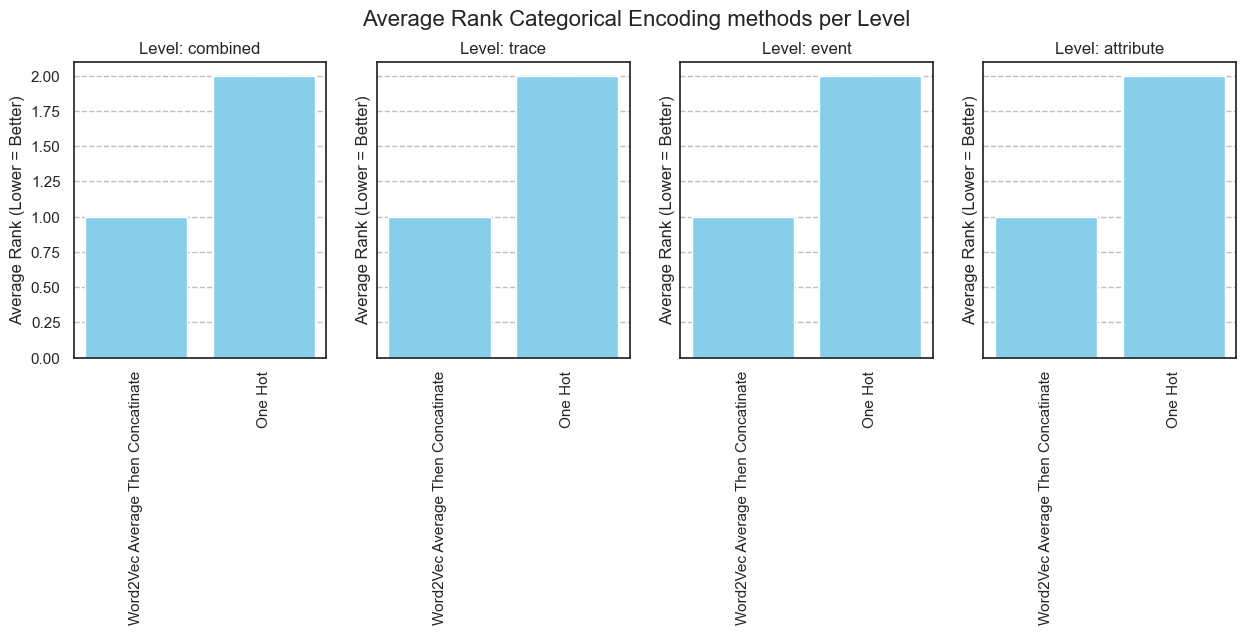

In [224]:
plot_rankings(average_rank_df, rank_column='average_rank')